In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
from quspin.operators import quantum_LinearOperator
from quspin.operators import quantum_operator
plt.rcParams['figure.figsize'] = [10, 8]

In [2]:
def stringbox(lst, caption):
    return caption + "-" * (100 - len(caption))+"\n" + str(lst) + "\n" + "-" * 100

## Model parameters

In [3]:
N = 8
N_filled = N // 2
E_neg1 = 0
P_neg1 = np.exp(-1j * E_neg1)
t = -0.5
g = 0
m = 0.8
PBC = True

## Real-Time Dynamics parameters

In [4]:
T = 3
timesteps = 30

dt = T / timesteps

## Creating fermion spectrum 

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


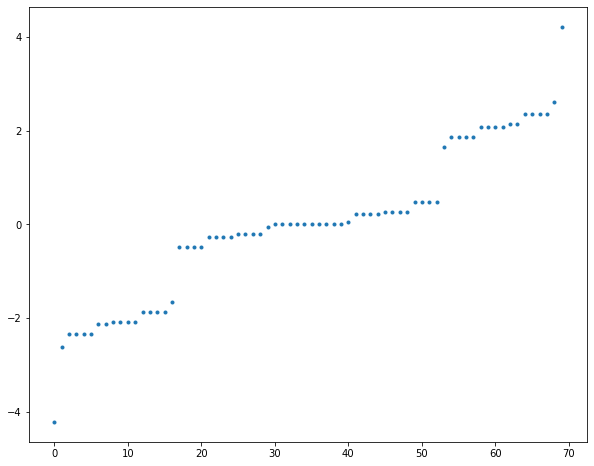

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [5]:
fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
fermion_basis_m1 = spinless_fermion_basis_1d(L=N, Nf=N_filled-1)
basis_full = spinless_fermion_basis_1d(L=N)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

def E_squared(n):
    E_const = E_neg1 + (n + 1) // 2
    s_coupling = []
    d_coupling = []
    for i in range(n + 1):
        s_coeff = 2 * E_const * -g
        s_coupling += [[s_coeff, i, i]]
        for j in range(n + 1):
            d_coeff = -g
            d_coupling += [[d_coeff, i, i, j, j]]
    return [["+-", s_coupling], ["+-+-", d_coupling]]
for i in range(N):
    static_terms += E_squared(i)

### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
fermion_eigvals = H.eigvalsh()
plt.plot(fermion_eigvals, ".")
plt.show()

### Take a copy for real-time dynamics later
H_init = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.complex64)

In [6]:
E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
psi_i = V_init[:,0]
psi_i = psi_i.reshape((-1,))
del H_init

## Real-Time Dynamics

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
# T =  0.0
0.0	 1.991388679375239e-08
0.1	 0.002383980436988995
0.2	 0.009594691459098763
# T =  0.30000000000000004
0.30000000000000004	 0.0218142299563444
0.4	 0.039365697104978566
0.5	 0.0627464203244571
# T =  0.6000000000000001
0.6000000000000001	 0.09268254813474971
0.7000000000000001	 0.13021367798453595
0.8	 0.17681328926174122
# T =  0.9
0.9	 0.23451029861582945
1.0	 0.30572436139517156
1.1	 0.3912344470376187
# T =  1.2000000000000002
1.2000000000000002	 0.4818745766393829
1.3	 0.5600759301090215
1.4000000000000001	 0.6318785303077646
# T =  1.5
1.5	 0.6312537471701718
1.6	 0.5108763624222147
1.7000000000000002	 0.39200294389678836
# T =  1.8
1.8	 0.29997796151066064
1.9000000000000001	 0.22879921951811305
2.0	 0.17278370088446773
# T =  2.1
2.1	 0.12826152749726458
2.2	 0.0928892535091333
2.3000000000000003	 0.0651325397708552
# T =  2.4000000000000004
2.4000000000000004	 0.0439676752902993

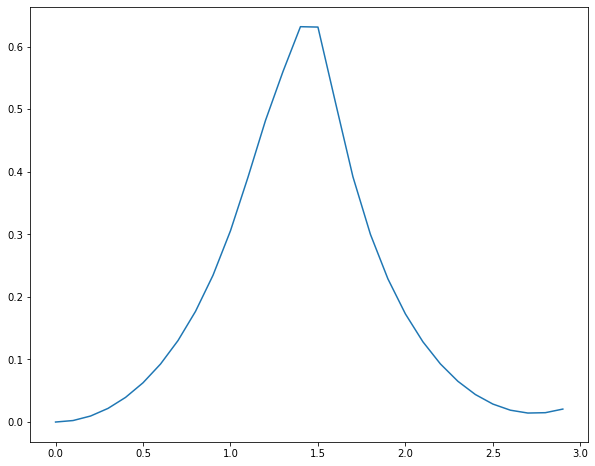

In [7]:
### Defining time-evolution hamiltonian
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[-m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
for i in range(N):
    static_terms += E_squared(i)

H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.complex64)

### This is where timesteps and total time T are used

##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
# construct piece-wise constant unitaries
expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
# auxiliary array for memory efficiency
psi=psi_i.copy().astype(np.complex128)
work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
# prepare output
loschmidt = []
for i in range(len(times)):
    if i % (len(times)//10) == 0:
        print("# T = ",times[i])
    Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
    print(f"{times[i]}\t {Lt[i]}")
    loschmidt += [Lt[i]]
    expH.dot(psi,work_array=work_array,overwrite_v=True)
# END of time evolution
plt.plot(times, loschmidt)

## Finding Correlators

In [8]:
def c_operator(n):
    cdag_static = [["-",[[1.0,n]]]]
    cdagn = quantum_LinearOperator(cdag_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
    return(cdagn)
annihilators = [c_operator(n) for n in range(N)]

In [9]:
##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)

# array to store correlators expectations from psi(t,n) to psi(0,0)
correlators = np.zeros((N,len(times)),dtype=np.complex128)

P_Nhalf = fermion_basis.get_proj(dtype=np.float64)
P_Nhalfminus1 = fermion_basis_m1.get_proj(dtype=np.float64)

for n in range(0, N, 2): #loop over all site pairings
    for i in range(len(times)): #loop over times (for annhilator location)
        # Even Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expmiH = expm_multiply_parallel((np.transpose(P_Nhalfminus1).dot(P_Nhalf.dot(H.tocsr().dot(np.transpose(P_Nhalf)))).dot(P_Nhalfminus1)),a=-1j*dt*i,dtype=dtype_cmplx)
        expiH = expm_multiply_parallel(H.tocsr(),a=1j*dt*i,dtype=dtype_cmplx)

        expiH.dot(leftPsi,overwrite_v=True) 
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

        correlators[n,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
        
        # Odd Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expiH.dot(leftPsi,overwrite_v=True) 
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

        correlators[n+1,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
    
# correlators = correlators#/(len(times)/dt) # Averaging over N so that it is actually an expectation value
# END of time evolution

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [10]:
correlatorfft = []
for i in range(len(correlators[0, :])):
    fftsum = np.fft.fft(correlators[::2,i]) + np.fft.fft(correlators[1::2,i])
    correlatorfft.append(fftsum)
    
correlatorfft = np.array(correlatorfft)

# Fix the correlatorFFT to be symmetric
mode_count = correlatorfft.shape[1]
BZ_edge = mode_count // 2 + 1
wrap_order = (np.arange(mode_count) + BZ_edge) % mode_count
print(wrap_order)
correlatorfft = correlatorfft[:, wrap_order]

[3 0 1 2]


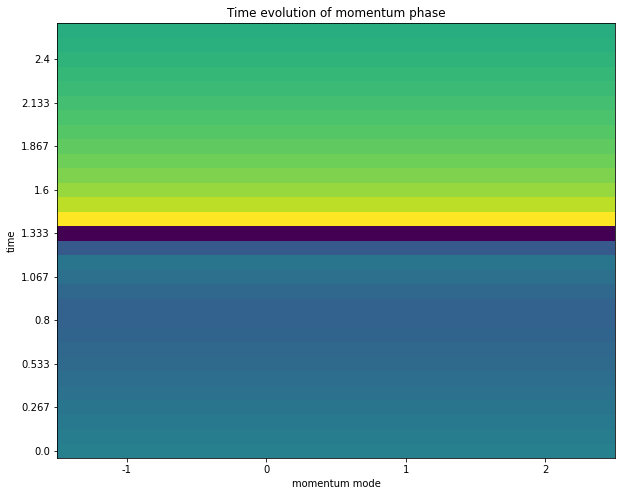

In [11]:
# plt.plot(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)))
plt.xlabel("momentum mode")
plt.ylabel("time")
plt.title("Time evolution of momentum phase")
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,N//2,step_x) # pixel count at label position
x_labels = np.arange(N//4-N//2+1, N//4+1) # labels you want to see
plt.xticks(x_positions, x_labels)
y_tickcount = 10 # How many labels on y axis
y_positions = np.arange(0,int(T/dt), int((T/dt)/y_tickcount)) # pixel count at label position
y_labels = np.round(np.linspace(0,abs(T*m),y_tickcount), 3) # labels you want to see
plt.yticks(y_positions, y_labels)
plt.imshow(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)), aspect='auto', origin='lower')

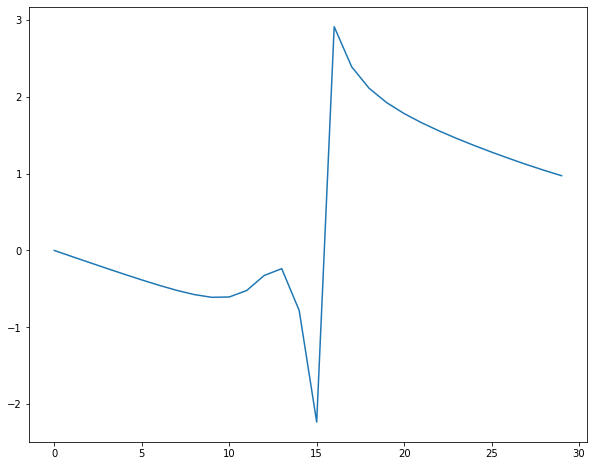

In [12]:
phases = np.arctan2(np.imag(correlatorfft), np.real(correlatorfft))
plt.plot(phases[:,0])
plt.show()

## Correlator code from Niklas

Symmetry checks passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Symmetry checks passed!
N8_Gt_n0_done
Symmetry checks passed!
N8_Gt_n1_done
Symmetry checks passed!
N8_Gt_n2_done
Symmetry checks passed!
N8_Gt_n3_done
Symmetry checks passed!
N8_Gt_n4_done
Symmetry checks passed!
N8_Gt_n5_done
Symmetry checks passed!
N8_Gt_n6_done
Symmetry checks passed!
N8_Gt_n7_done
[ 0.10959597+0.00000000e+00j  0.89040388+0.00000000e+00j
  0.04691311+2.84322665e-09j -0.04691312+4.13931327e-09j
 -0.01576973+1.59623911e-09j  0.01576972-5.24410639e-09j
  0.04691312+9.64757532e-09j -0.04691313-5.49267215e-09j]


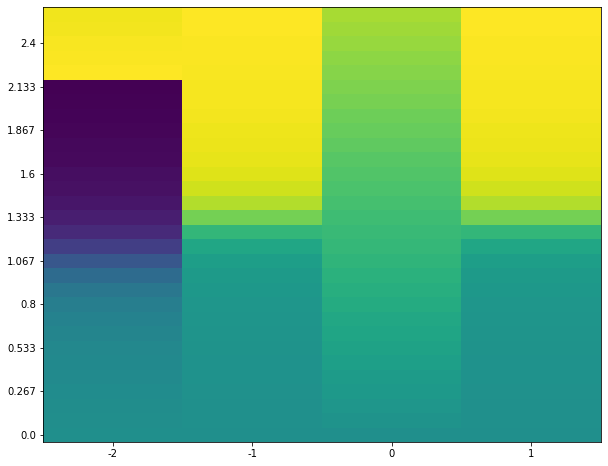

[ 0.00000000e+00 -3.86525743e-18 -2.76089816e-18 -1.60132093e-17
 -2.04306464e-17  6.07397595e-18  6.07397595e-18  1.49088501e-17
 -2.76089816e-18  5.02483465e-17  5.02483465e-17  1.49088501e-17
  3.25785983e-17  5.02483465e-17  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
[ 0.00000000e+00  5.79788614e-18  8.00660467e-18 -8.28269448e-19
  3.58916761e-18 -5.24570651e-18 -1.40805806e-17 -1.40805806e-17
  1.24240417e-17 -5.24570651e-18 -5.24570651e-18 -5.24570651e-18
  1.24240417e-17 -5.24570651e-18 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]


In [13]:
psi_init = psi_i.copy().astype(np.complex128)

# apply c_0 & c_1 to initial state
c0_static = [["-",[[1.0,0]]]]
c0 = quantum_LinearOperator(c0_static,basis=basis_full,dtype=np.float64,check_herm=False,check_pcon=False)
psi_init_c0 = np.transpose(P_Nhalfminus1).dot(c0.dot(P_Nhalf.dot(psi_init)))
# del c0
c1_static = [["-",[[1.0,1]]]]
c1 = quantum_LinearOperator(c1_static,basis=basis_full,dtype=np.float64,check_herm=False,check_pcon=False)
psi_init_c1 = np.transpose(P_Nhalfminus1).dot(c1.dot(P_Nhalf.dot(psi_init)))
# del c1
H_quenched = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis_m1, dtype=np.float64)
# evolving in time (forward)
psi_t_c0 = H_quenched.evolve(psi_init_c0,0,times)#,solver_name='dopri5',atol=1e-16,rtol=1e-16)
psi_t_c1 = H_quenched.evolve(psi_init_c1,0,times)#,solver_name='dopri5',atol=1e-16,rtol=1e-16)
# del H_quenched
#print(np.shape(psi_t))
H_quenched_r =  -hamiltonian(static_terms,dynamic_terms,basis=fermion_basis,dtype=np.float64)
Gnt_all = []
for n in range(N):
    Gnt = np.zeros(len(times),dtype=np.complex128)
    # apply c_n^\dagger to evolved states
    psi_t_cn = []
    cn_static = [["+",[[1.0,n]]]]
    cn = quantum_LinearOperator(cn_static,basis=basis_full,dtype=np.float64,check_herm=False,check_pcon=False)
    for t in range(len(times)):
        if n%2 == 0:
            psi_t_cn.append( np.transpose(P_Nhalf).dot(cn.dot(P_Nhalfminus1.dot(psi_t_c0[:,t]))) )
        if n%2 == 1:
            psi_t_cn.append( np.transpose(P_Nhalf).dot(cn.dot(P_Nhalfminus1.dot(psi_t_c1[:,t]))) )
    del cn
    psi_t_cn = np.array(psi_t_cn)
    #print(np.shape(psi_t_cn))
    # evolve backwards in time & get the correlators
    for t in range(len(times)):
        psi_t_cn[t,:] = H_quenched_r.evolve(psi_t_cn[t,:],0,times[t])
        Gnt[t] = np.vdot(psi_init,psi_t_cn[t,:])
    print('N'+str(N)+'_Gt_n'+str(n)+'_done')
    Gnt_all.append(Gnt)
Gnt_all = np.array(Gnt_all)
print(Gnt_all[:,0])
#np.save(folder_save+'/TwoTime_correlators',Gnt_all)
Nt = len(times)
Gnt_half = np.zeros((N//2,Nt),dtype=np.complex128)
for n in range(N//2):
    Gnt_half[n,:] = Gnt_all[2*n,:] + Gnt_all[2*n+1,:]
Gkt = np.fft.fft(Gnt_half,axis=0)

# Fix the correlatorFFT to be symmetric
diff = correlatorfft - Gkt.T
correlatorfft = Gkt.T
# mode_count = correlatorfft.shape[1]
# BZ_edge = mode_count // 2 + 1
# wrap_order = (np.arange(mode_count) + BZ_edge) % mode_count
# print(wrap_order)
# correlatorfft = correlatorfft[:, wrap_order]
# plt.xlabel("momentum mode")
# plt.ylabel("time")
# plt.title("Time evolution of momentum phase")

#Plot FFT
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,N//2,step_x) # pixel count at label position
x_labels = np.arange(N//4-N//2, N//4) # labels you want to see
plt.xticks(x_positions, x_labels)
y_tickcount = 10 # How many labels on y axis
y_positions = np.arange(0,int(T/dt), int((T/dt)/y_tickcount)) # pixel count at label position
y_labels = np.round(np.linspace(0,abs(T*m),y_tickcount), 3) # labels you want to see
plt.yticks(y_positions, y_labels)
plt.imshow(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)), aspect='auto', origin='lower')
plt.show()

Lt_from_Gkt = -np.sum(np.log(np.abs(Gkt)),axis=0)/N
# np.savetxt(folder_save+'/rate_TwoTime',np.array(Lt_from_Gkt)/a)
Nk, Nt = np.shape(Gkt)
dphi_kt_k = np.zeros((Nk,Nt-1))
dphi_kt_t = np.zeros((Nk,Nt-1))
Fkt = np.zeros((Nk,Nt-2))
for k in range(Nk):
    for t in range(Nt-1):
        dphi_kt_k[k,t] = np.angle(Gkt[(k+1)%Nk,t]/Gkt[k,t])
        dphi_kt_t[k,t] = np.angle(Gkt[k,t+1]/Gkt[k,t])
for k in range(Nk):
    for t in range(Nt-2):
        Fkt[k,t] = (dphi_kt_k[k,t] + dphi_kt_t[(k+1)%Nk,t]) - (dphi_kt_k[k,t+1] + dphi_kt_t[k,t])
Fkt_ksum1 = np.zeros(Nt-2)
Fkt_ksum2 = np.zeros(Nt-2)
for k in range(Nk//2):
    Fkt_ksum1 += Fkt[(k),:]/2/np.pi
    Fkt_ksum2 += Fkt[(k+Nk//2),:]/2/np.pi
n1 = []
n2 = []
for t in range(Nt-2):
    ntau1 = 0
    ntau2 = 0
    for tau in range(0,t):
        ntau1 += Fkt_ksum1[tau]
        ntau2 += Fkt_ksum2[tau]
    n1.append(ntau1)
    n2.append(ntau2)
n1 = np.array(n1)
n2 = np.array(n2)
print(n1)
print(n2)

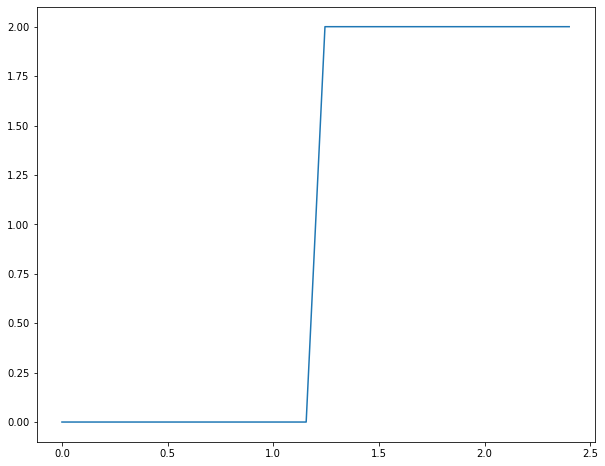

Times where (n1,n2) jump: --------------------------------------------------------------------------
(14, 14)
----------------------------------------------------------------------------------------------------


In [43]:
diff_corr = np.array(Gnt_all) - correlators
plt.plot(np.linspace(0, T * m, len(n1)), (n1-n2))
plt.show()
criticaltimes = (np.where(n1>.1)[0][0],np.where(n2< -.1)[0][0])
print(stringbox(criticaltimes,"Times where (n1,n2) jump: "))

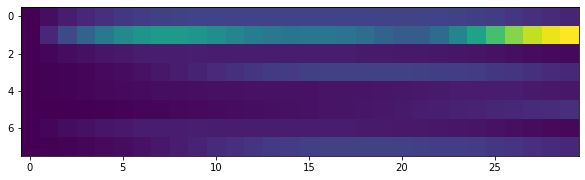

In [44]:
plt.imshow(np.abs(correlators - Gnt_all))